<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$

#Factor de regularización para asegurar una energía negativa en el aprendizaje no supervisado
$$ \textit{R}\left ( r_{ij} \right ) =  \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right]  $$

# Para asegurar que la energía sea negativa, basta con asegurar que la sección que involucra la distancia sea negativa

# Librerias y Constantes

In [1]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [19]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 4.806e+16 #Fondo del pozo del aluminio (ev/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 6.261482e+22 #Fondo del pozo mercurio (ev/mol)
Sigma = np.sqrt(SigmaAl*SigmaHg)
Epsilon = np.sqrt(EpsilonAl*EpsilonHg)

# Creación de la muestra

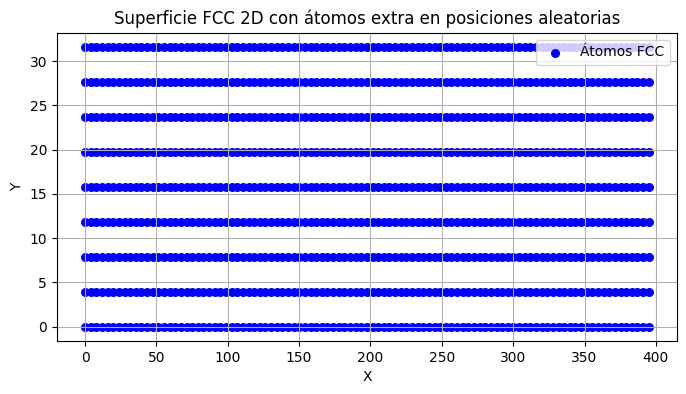

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 50
celdas_alto = 4
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0, 0], [0.5, 0], [0, 0.5], [0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
x, y = [], []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        # Posiciones de átomos en cada celda FCC
        atoms = base_fcc + np.array([i * a, j * a])
        x.extend(atoms[:, 0])
        y.extend(atoms[:, 1])

# Agregar átomos adicionales en la última fila y columna
# Última columna
for j in range(celdas_alto):
    x.append(celdas_largo * a)
    y.append(j * a + 0)  # Átomo en el vértice
    x.append(celdas_largo * a)
    y.append(j * a + 0.5 * a)  # Átomo en el centro de la cara

# Última fila
for i in range(celdas_largo):
    x.append(i * a + 0)
    y.append(celdas_alto * a)
    x.append(i * a + 0.5 * a)
    y.append(celdas_alto * a)

# Añadir el átomo del vértice superior derecho
x.append(celdas_largo * a)
y.append(celdas_alto * a)

fcc_positions = np.column_stack((x, y))  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
# Graficar la estructura FCC con átomos adicionales
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Creación de los iones que se van a adsorber

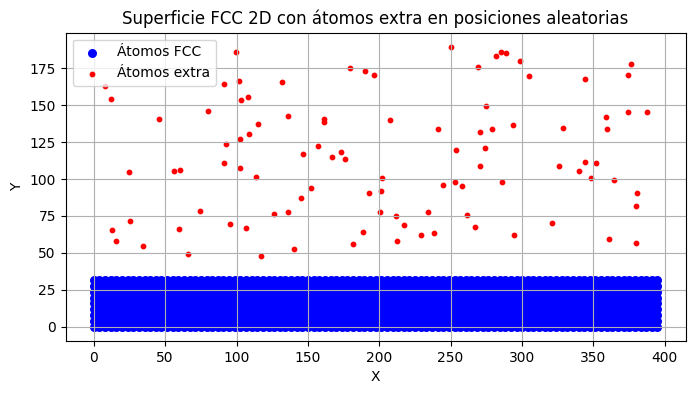

In [26]:
num_atomos_extra = 100  # Número de átomos extra que se colocarán al azar

# Generar átomos adicionales en posiciones aleatorias por encima de la superficie
x_extra = np.random.uniform(0, celdas_largo * a, num_atomos_extra)
y_extra = np.random.uniform(celdas_alto * a + 2*a, celdas_alto * a + 20*a, num_atomos_extra)  # Y mayor que la parte más alta
extra_positions = np.column_stack((x_extra, y_extra))  # Matriz con posiciones de átomos extra

# Graficar las posiciones
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.scatter(extra_positions[:, 0], extra_positions[:, 1], color='red', s=10, label="Átomos extra")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [27]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon=Epsilon, sigma=Sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    """
    sigma = tf.cast(sigma, tf.float32)
    epsilon = tf.cast(epsilon, tf.float32)
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon=Epsilon, sigma=Sigma,lam_=1.0):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    # Expandir dimensiones para obtener todas las combinaciones de distancias
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción
    lj_energy = lennard_jones_potential(r, epsilon, sigma)  # (num_iones, num_superficie)
    reg_term = tf.reduce_mean(lj_energy/4*epsilon,axis=1)
    # Energía total para cada ion
    E_total = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)

    # Devolver la energía promedio del sistema
    energy_avg = tf.reduce_mean(lam_*E_total+(1-lam_)*reg_term)  # Promedio sobre los iones (escalar)

    return energy_avg

In [28]:
#tensorflow data
Xh = tf.convert_to_tensor(extra_positions,dtype=tf.float32)
Xt = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
lam_LJ = 0.4
lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [29]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

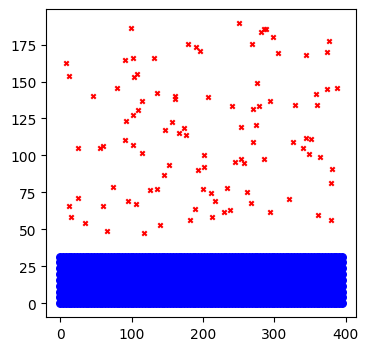

Epoch 1/50
Loss: -2.7868934466823703e-06 MeanGrad: [3.4967762e-10 5.2556293e-09]


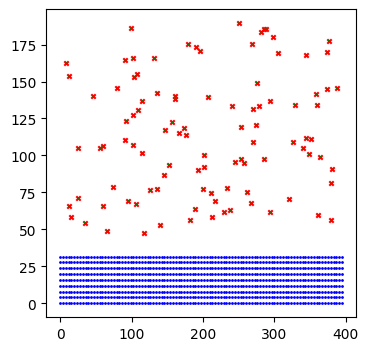

Epoch 2/50
Loss: -2.590980329841841e-06 MeanGrad: [3.5067835e-10 5.0553592e-09]


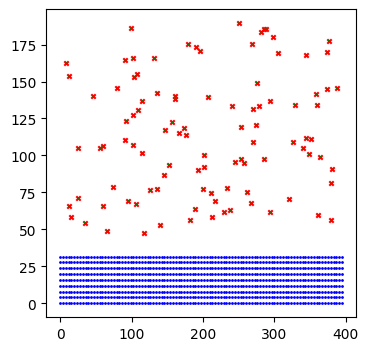

Epoch 3/50
Loss: -2.396261606918415e-06 MeanGrad: [1.7443769e-10 4.7592970e-09]


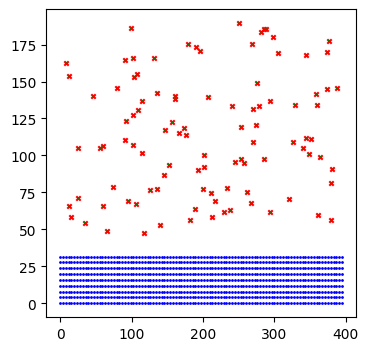

Epoch 4/50
Loss: -3.844661478069611e-06 MeanGrad: [1.2727905e-09 9.1541139e-09]


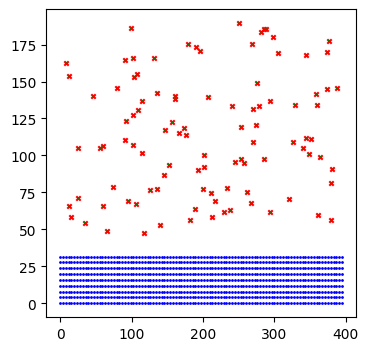

Epoch 5/50
Loss: -2.5501547042949824e-06 MeanGrad: [1.0964225e-11 5.2536859e-09]


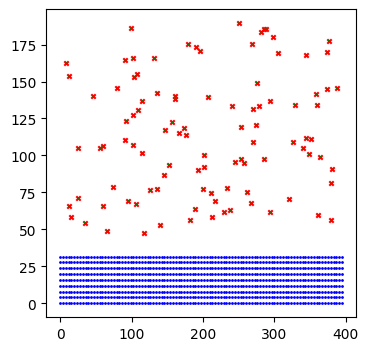

Epoch 6/50
Loss: -2.6067841645271983e-06 MeanGrad: [-1.5965215e-10  5.1477724e-09]


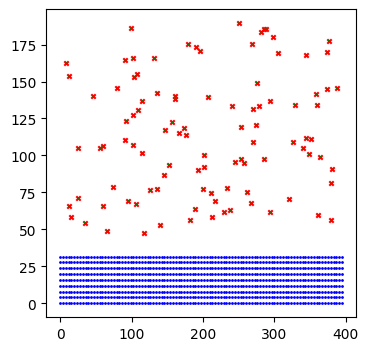

Epoch 7/50
Loss: -3.076891289310879e-06 MeanGrad: [-1.0694791e-09  7.1032709e-09]


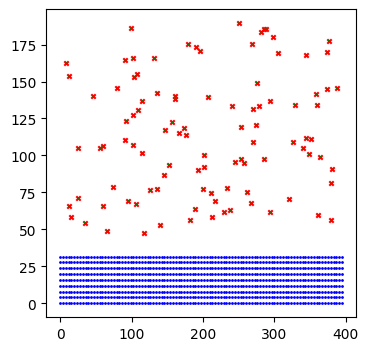

Epoch 8/50
Loss: -1.983341007871786e-06 MeanGrad: [1.7444776e-10 3.4355776e-09]


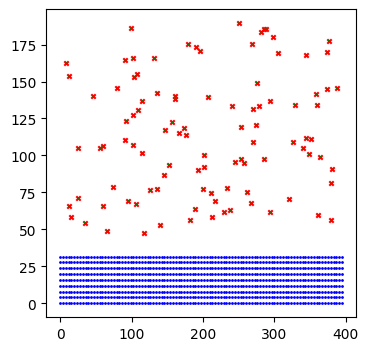

Epoch 9/50
Loss: -2.5584758986951783e-06 MeanGrad: [-1.1207312e-10  5.1814495e-09]


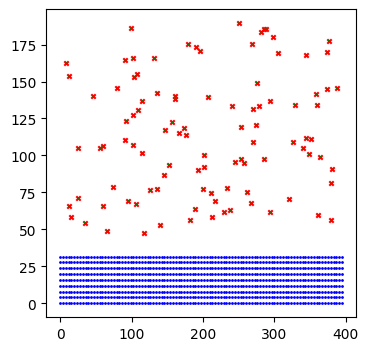

Epoch 10/50
Loss: -3.0502724257530645e-06 MeanGrad: [9.490924e-10 6.477092e-09]


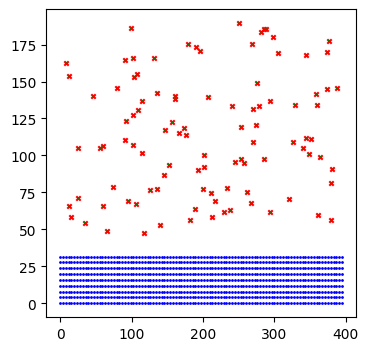

Epoch 11/50
Loss: -2.986948629768449e-06 MeanGrad: [-3.8701489e-10  6.8980097e-09]


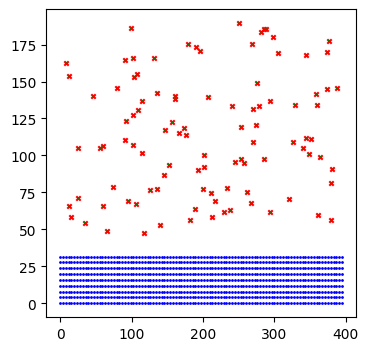

Epoch 12/50
Loss: -2.4421356101811398e-06 MeanGrad: [-4.3122447e-10  5.0251434e-09]


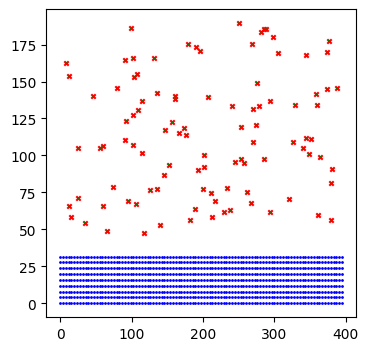

Epoch 13/50
Loss: -2.5608594569348497e-06 MeanGrad: [5.577705e-10 5.203979e-09]


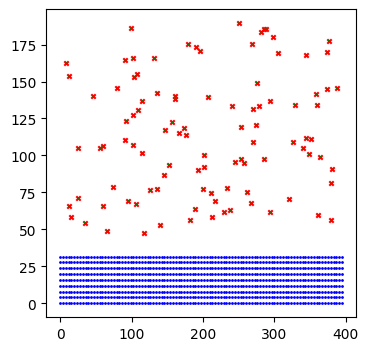

Epoch 14/50
Loss: -2.4671339815540705e-06 MeanGrad: [2.1536507e-10 5.4612239e-09]


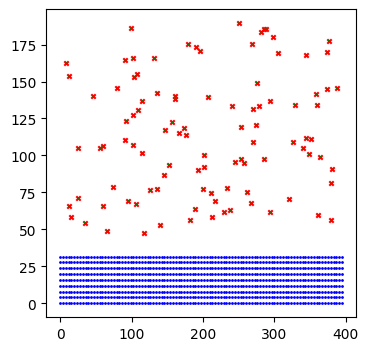

Epoch 15/50
Loss: -2.7528171813173685e-06 MeanGrad: [-3.6090492e-10  6.2603003e-09]


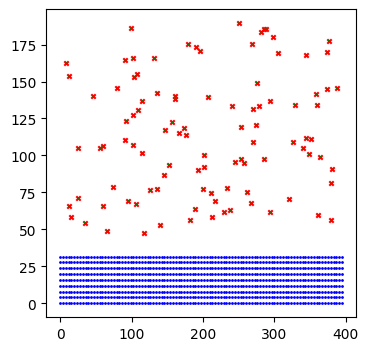

Epoch 16/50
Loss: -3.4476042856113054e-06 MeanGrad: [-6.083541e-10  8.392458e-09]


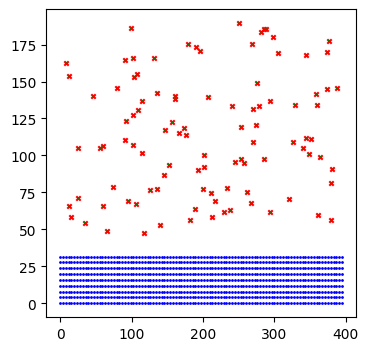

Epoch 17/50
Loss: -2.6187676667177584e-06 MeanGrad: [-3.1020370e-10  5.0780464e-09]


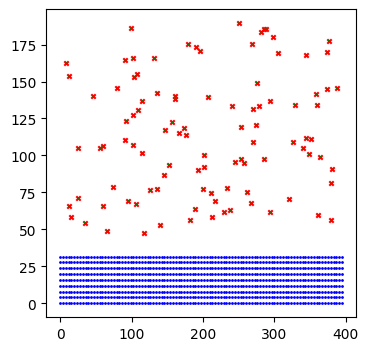

Epoch 18/50
Loss: -2.0966247120668413e-06 MeanGrad: [-4.4595938e-10  3.7709036e-09]


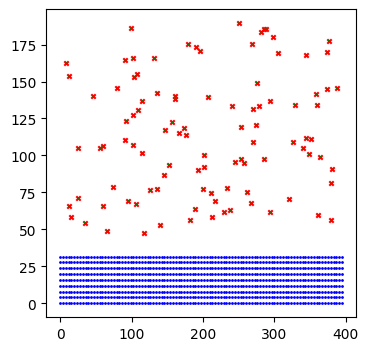

Epoch 19/50
Loss: -1.9990181954199215e-06 MeanGrad: [-9.3349654e-11  3.2115191e-09]


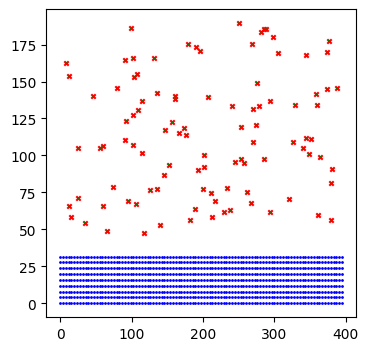

Epoch 20/50
Loss: -2.1058442598587135e-06 MeanGrad: [-1.08069234e-10  3.78586185e-09]


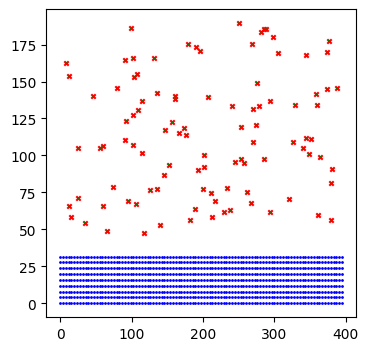

Epoch 21/50
Loss: -2.576854058133904e-06 MeanGrad: [7.7722578e-11 5.2071543e-09]


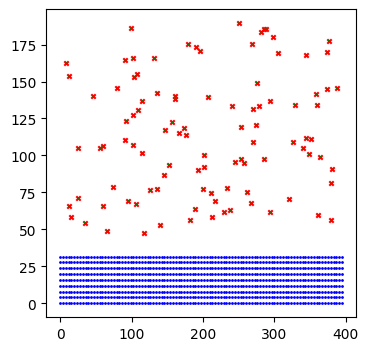

Epoch 22/50
Loss: -2.8431413738871925e-06 MeanGrad: [-5.1014687e-10  5.8467617e-09]


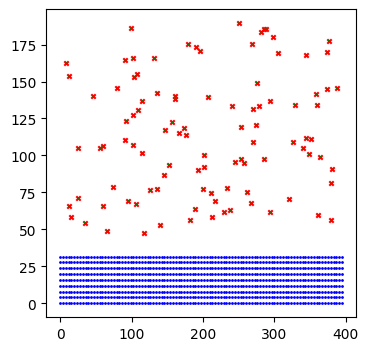

Epoch 23/50
Loss: -3.5838447729474865e-06 MeanGrad: [3.6406583e-10 9.1628314e-09]


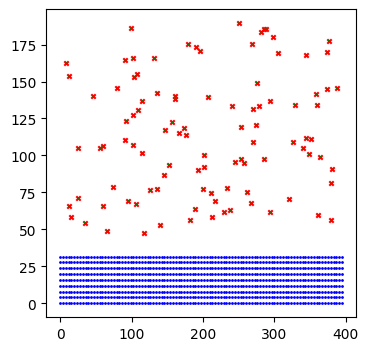

Epoch 24/50
Loss: -2.6790023639478022e-06 MeanGrad: [-1.2521509e-10  5.3290621e-09]


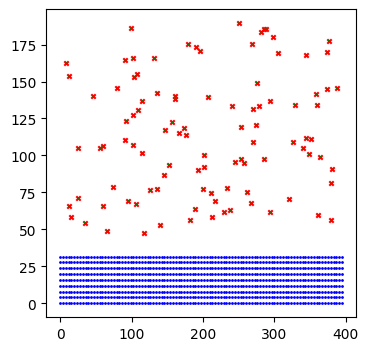

Epoch 25/50
Loss: -3.52157985616941e-06 MeanGrad: [5.461360e-10 7.808083e-09]


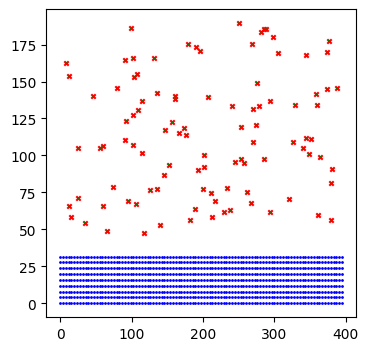

Epoch 26/50
Loss: -3.512573812258779e-06 MeanGrad: [-2.647416e-10  8.726407e-09]


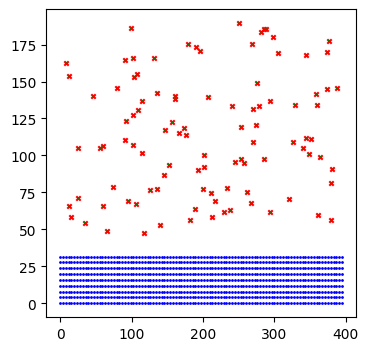

Epoch 27/50
Loss: -2.5364167868247023e-06 MeanGrad: [1.825578e-10 5.854797e-09]


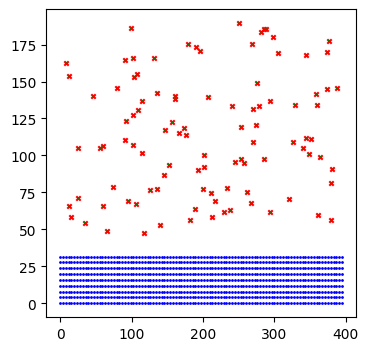

Epoch 28/50
Loss: -4.34737103205407e-06 MeanGrad: [-7.8431789e-10  1.0961124e-08]


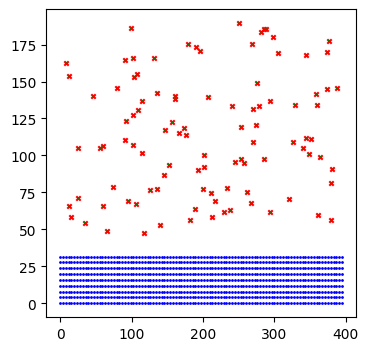

Epoch 29/50
Loss: -2.7338237487128936e-06 MeanGrad: [-1.0642518e-09  5.8473599e-09]


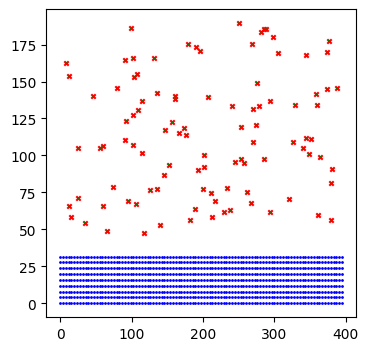

Epoch 30/50
Loss: -3.16449768433813e-06 MeanGrad: [6.803505e-10 6.412557e-09]


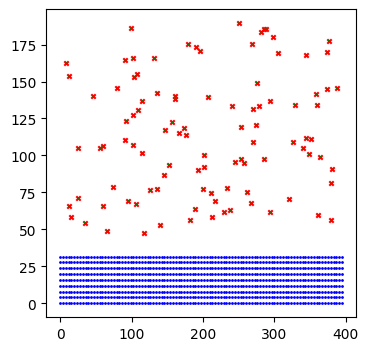

Epoch 31/50
Loss: -2.7977721401839517e-06 MeanGrad: [4.6717269e-10 5.7082916e-09]


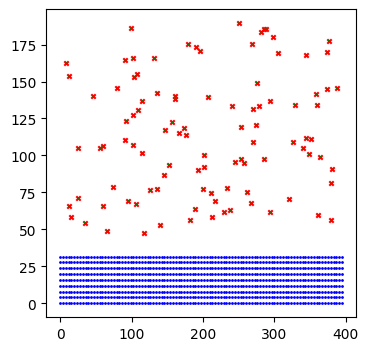

Epoch 32/50
Loss: -3.067631723752129e-06 MeanGrad: [5.1705068e-10 6.2340417e-09]


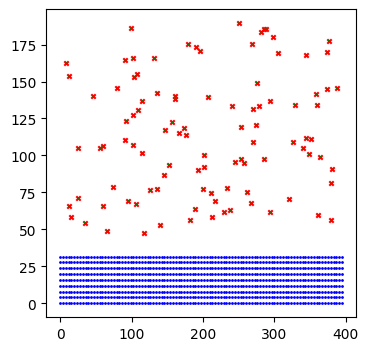

Epoch 33/50
Loss: -2.7252331165072974e-06 MeanGrad: [7.681579e-10 5.528015e-09]


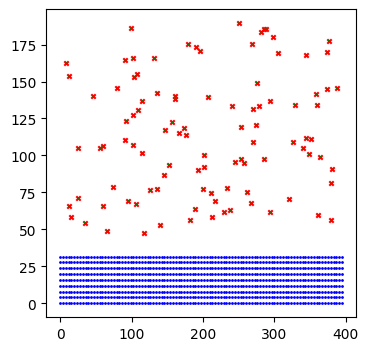

Epoch 34/50
Loss: -4.300022283132421e-06 MeanGrad: [-7.0239670e-10  1.0355142e-08]


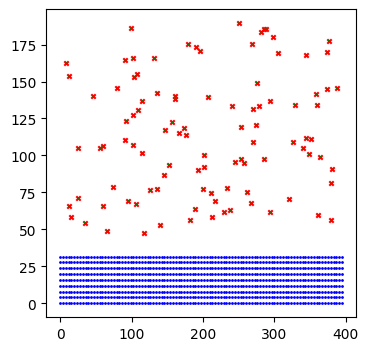

Epoch 35/50
Loss: -3.055012257391354e-06 MeanGrad: [-7.0419316e-11  6.7478556e-09]


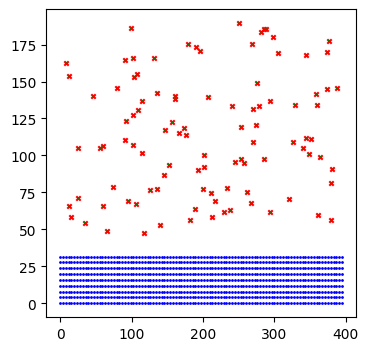

Epoch 36/50
Loss: -3.0068786145420745e-06 MeanGrad: [-9.9535902e-10  6.5098376e-09]


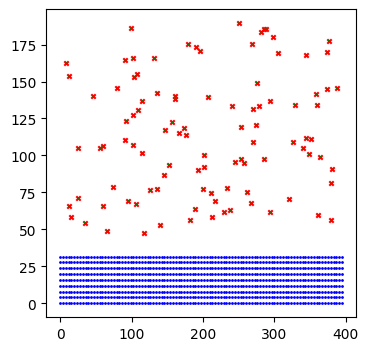

Epoch 37/50
Loss: -2.996896000695415e-06 MeanGrad: [-3.6763878e-10  5.7173342e-09]


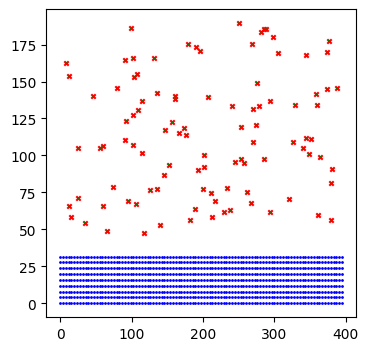

Epoch 38/50
Loss: -3.0992594020062825e-06 MeanGrad: [8.2485352e-10 6.4768426e-09]


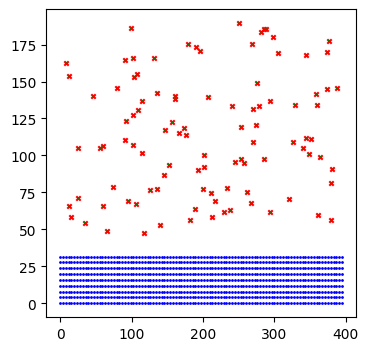

Epoch 39/50
Loss: -3.51392350239621e-06 MeanGrad: [5.536139e-10 7.731138e-09]


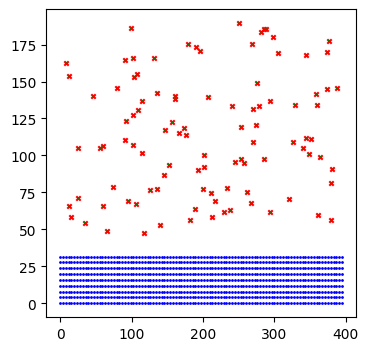

Epoch 40/50
Loss: -2.410822389720124e-06 MeanGrad: [6.3937994e-10 4.8967981e-09]


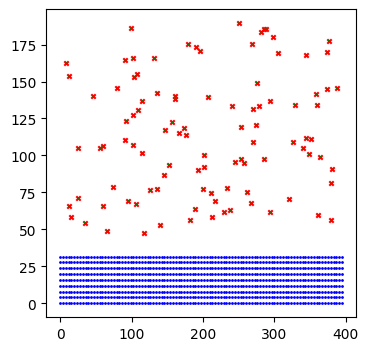

Epoch 41/50
Loss: -4.399671070132172e-06 MeanGrad: [-2.0626803e-10  1.0418983e-08]


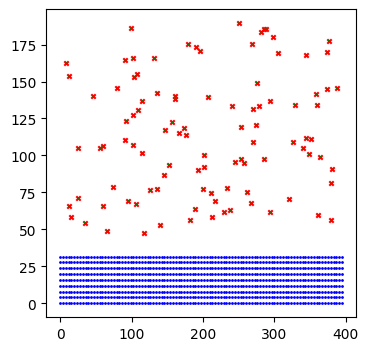

Epoch 42/50
Loss: -3.3150035960716195e-06 MeanGrad: [-7.3349646e-11  7.5480804e-09]


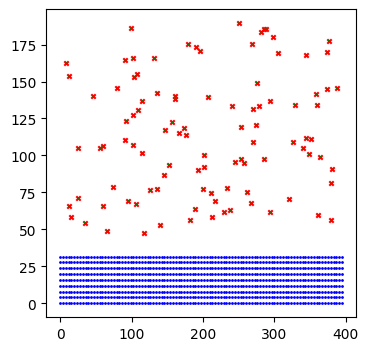

Epoch 43/50
Loss: -3.373926347194356e-06 MeanGrad: [3.2218317e-10 7.4263693e-09]


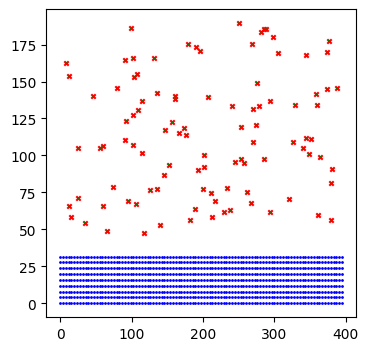

Epoch 44/50
Loss: -2.807611508615082e-06 MeanGrad: [-8.1161694e-10  5.6126841e-09]


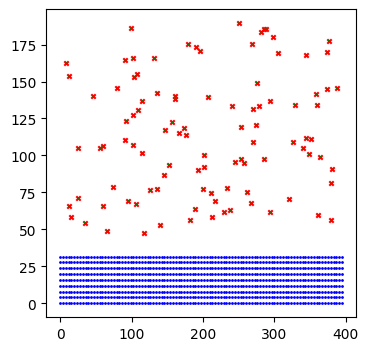

Epoch 45/50
Loss: -2.8840292998211225e-06 MeanGrad: [9.7758535e-10 6.1176992e-09]


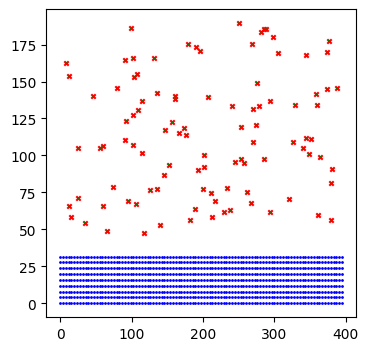

Epoch 46/50
Loss: -3.3952301237150095e-06 MeanGrad: [-5.0415356e-11  7.4224902e-09]


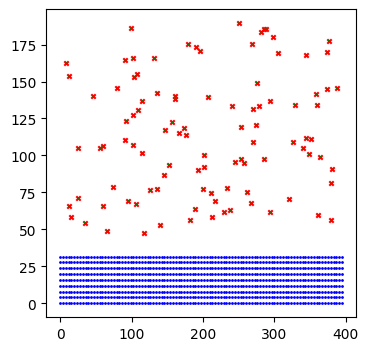

Epoch 47/50
Loss: -3.3923474802577402e-06 MeanGrad: [8.2905266e-11 7.8290299e-09]


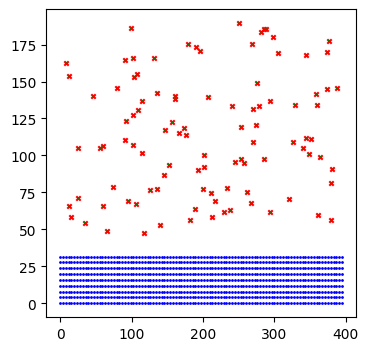

Epoch 48/50
Loss: -2.9619657198054483e-06 MeanGrad: [-7.2497383e-11  6.3333054e-09]


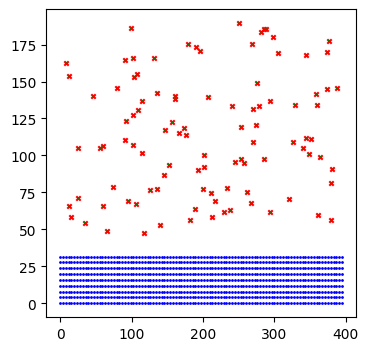

Epoch 49/50
Loss: -2.332582653252757e-06 MeanGrad: [2.9191826e-11 4.0613428e-09]


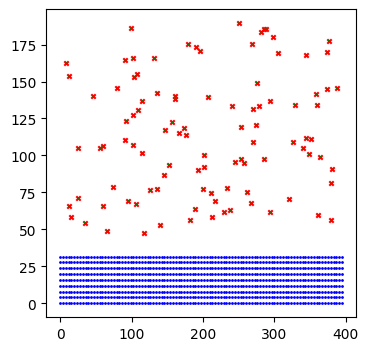

Epoch 50/50
Loss: -2.640515731400228e-06 MeanGrad: [4.3639176e-10 5.3971063e-09]


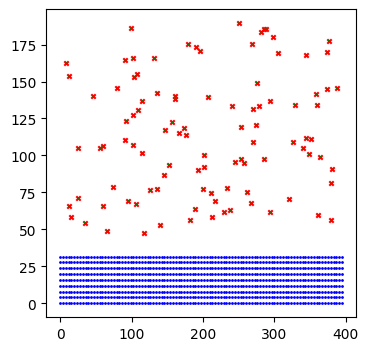

In [30]:
Xh_ =  Xh.numpy()
plt.figure(figsize=(4,4))
plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=30)
plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 1e-1
batch_size = 256
epochs = 50
decay_rate = 0.2

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    for x_batch in tf.data.Dataset.from_tensor_slices(Xt).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(Xh)
        H_loss_ = H_loss(Xh,x_batch,lam_)
      grad_ = g.gradient(H_loss_, Xh)
      Xh = Xh -eta*grad_
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    Xh_ =  Xh.numpy()
    gradN = -10*eta*grad_.numpy()


    plt.figure(figsize=(4,4))
    plt.scatter(fcc_positions[:,0],fcc_positions[:,1],c = 'b',s=1)
    plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(Xh_[:,0],Xh_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

# Tareas Luker - Sofia y Juan Lugo


## Unsupervised Deep Embedding for Clustering Analysis

https://proceedings.mlr.press/v48/xieb16.pdf

https://github.com/HaebinShin/dec-tensorflow


## Tareas Sofia:

Revisar matemática PRI

Revisar Paper Unsupervised Deep Embedding for Clustering Analysis

Implementar DEC según github compartido y aplicar sobre experimento de goku y sobre Fashion Mnist

## Tareas Juan Lugo

Revisar modelo tabnet

https://paperswithcode.com/method/tabnet

Revisar implementaciones sobre keras

https://github.com/jeyabbalas/tabnet

Aplicar sobre base de datos fifa19 curso aprendizaje de máquina para luego aplicar a Luker

## Objetivo luker

- Unir DCE/PRI sofia con Tabnet Lugo, con modelo generativo para lidear con generación de propiedades físico químicas desde espacio latente anotadores

## Tareas sofia y lugo

Revisar focal loss para lidear con datos desbalanceados

https://paperswithcode.com/method/focal-loss